In [2]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.9.2'

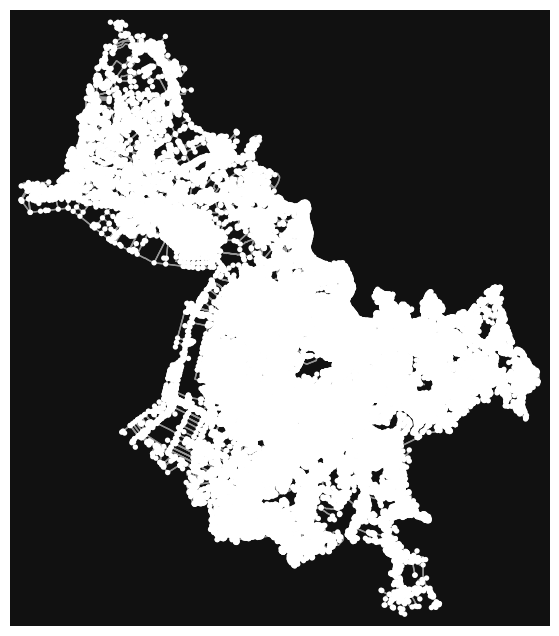

In [3]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Ho Chi Minh City, Vietnam", network_type="drive")
fig, ax = ox.plot_graph(G)

In [4]:
# Get area
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print(graph_area_m)

2086087321.376358


In [5]:
# show some basic stats about the network
stats=ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)
print(stats)

{'n': 103237, 'm': 239344, 'k_avg': 4.636787198388175, 'edge_length_total': 22289710.26700045, 'edge_length_avg': 93.12834358496745, 'streets_per_node_avg': 2.451679146042601, 'streets_per_node_counts': {0: 0, 1: 32848, 2: 164, 3: 61125, 4: 8968, 5: 111, 6: 21}, 'streets_per_node_proportions': {0: 0.0, 1: 0.3181804973023238, 2: 0.0015885777386014704, 3: 0.5920842333659444, 4: 0.0868680802425487, 5: 0.001075195908443678, 6: 0.00020341544213799316}, 'intersection_count': 70389, 'street_length_total': 11995777.592999838, 'street_segment_count': 126516, 'street_length_avg': 94.816288793511, 'circuity_avg': 1.0532048509421237, 'self_loop_proportion': 0.0008220304151253596, 'clean_intersection_count': 50599, 'node_density_km': 49.48834065674985, 'intersection_density_km': 33.742115815918375, 'edge_density_km': 10684.936358413872, 'street_density_km': 5750.371746224539, 'clean_intersection_density_km': 24.25545636633073}


In [6]:
n=2
pts = ox.utils_geo.sample_points(G, n)
print(pts)

/var/folders/ny/hxv5b40s3w93s_yc2kzgz28m0000gn/T/ipykernel_68660/73020187.py:2: UserWarning: graph should be undirected to avoid oversampling bidirectional edges
  pts = ox.utils_geo.sample_points(G, n)


u           v           key
7130821182  7130821173  0      POINT (106.63759 10.74944)
2471773878  2470745103  0      POINT (106.65415 10.84315)
dtype: geometry


/Users/kiettran/Projects/MapApi/.venv/lib/python3.11/site-packages/osmnx/utils_geo.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.default_rng().random(n), normalized=True)


In [7]:
points_coordinates = [(point.x, point.y) for point in pts]
points_coordinates

[(106.63758647464898, 10.749435660155392),
 (106.65415085865719, 10.843154951728943)]

In [8]:
def dijkstra(graph, source, target):
    # Initialize distances dictionary with source node having distance 0
    distances = {node: float('inf') for node in graph.nodes()}
    distances[source] = 0

    # Initialize priority queue
    priority_queue = [(0, source)]

    while priority_queue:
        # Pop node with minimum distance from priority queue
        current_distance, current_node = min(priority_queue)
        priority_queue.remove((current_distance, current_node))
            
        # If current node is the target, return the distance
        if current_node == target:
            return distances[target]

        # Iterate through neighbors of current node
        for neighbor in graph.neighbors(current_node):
            # Calculate new distance via current node to the neighbor
            distance = current_distance + graph[current_node][neighbor][0]['length']

            # If new distance is shorter, update distances dictionary and add to priority queue
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                priority_queue.append((distance, neighbor))

    # If target is unreachable from source, return None
    return None


In [9]:
def bellman_ford(graph, source, target):
    distances = {node: float('inf') for node in graph.nodes()}
    distances[source] = 0
    for _ in range(len(graph.nodes()) - 1):
        for u, v in graph.edges():
            distance = distances[u] + graph[u][v][0]['length']
            if distance < distances[v]:
                distances[v] = distance
    for u, v in graph.edges():
        if distances[u] + graph[u][v][0]['length'] < distances[v]:
            return None
    return distances[target]

In [38]:
def floyd_warshall(graph, source, target):
    # Initialize distance matrix
    num_nodes = len(graph.nodes())
    dist = [[float('inf')] * num_nodes for _ in range(num_nodes)]
    # Initialize diagonal with 0s and edges with their weights
    for u, v, w in graph.edges(data='length'):
        dist[u][v] = w
        dist[v][u] = w

    
    # Update distance matrix
    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    print(dist)

    # Retrieve shortest path distance between source and target from the distance matrix
    return dist[source][target]


In [44]:
# Create a simple weighted MultiDiGraph for testing
T = nx.MultiDiGraph()
T.add_nodes_from(['A', 'B', 'C', 'D', 'E'])
T.add_edge('A', 'B', length=6)
T.add_edge('A', 'D', length=7)
T.add_edge('B', 'C', length=5)
T.add_edge('B', 'D', length=8)
T.add_edge('B', 'E', length=float('inf'))
T.add_edge('C', 'B', length=float('inf'))
T.add_edge('D', 'C', length=float('inf'))
T.add_edge('D', 'E', length=9)
T.add_edge('E', 'C', length=7)
T.add_edge('E', 'A', length=2)

# Test the Bellman-Ford algorithm
source = 'A'
target = 'C'
shortest_path_distance = dijkstra(T, source, target)

# Output the result
if shortest_path_distance is None:
    print("Negative cycle detected, Bellman-Ford algorithm cannot find shortest path.")
else:
    print(f"Shortest path distance from {source} to {target}:", shortest_path_distance)


Shortest path distance from A to C: 11


In [45]:
# Create a simple weighted MultiDiGraph for testing
Tint = nx.MultiDiGraph()
Tint.add_nodes_from([0, 1, 2, 3, 4])  # Using numeric labels
Tint.add_edge(0, 1, length=6)
Tint.add_edge(0, 3, length=7)
Tint.add_edge(1, 2, length=5)
Tint.add_edge(1, 3, length=8)
Tint.add_edge(1, 4, length=float('inf'))
Tint.add_edge(2, 1, length=float('inf'))
Tint.add_edge(3, 2, length=float('inf'))
Tint.add_edge(3, 4, length=9)
Tint.add_edge(4, 2, length=7)
Tint.add_edge(4, 0, length=2)

# Test the Floyd-Warshall algorithm
source = 0  # Index of node labeled 0
target = 2  # Index of node labeled 2
shortest_path_distance = floyd_warshall(Tint, source, target)

# Output the result
if shortest_path_distance == float('inf'):
    print("There is no path between the source and target nodes.")
else:
    print(f"Shortest path distance from {source} to {target}:", shortest_path_distance)

[[4, 6, 9, 7, 2], [6, 12, 15, 8, 8], [9, 15, 14, 16, 7], [7, 8, 16, 14, 9], [2, 8, 7, 9, 4]]
Shortest path distance from 0 to 2: 9


In [ ]:
# Snap points to nearest nodes in the graph
source = ox.distance.nearest_nodes(G, pts.iloc[0].x, pts.iloc[0].y)
target = ox.distance.nearest_nodes(G, pts.iloc[1].x, pts.iloc[1].y)

# Check if source and target nodes are in the graph
if source not in G.nodes():
    print("Source node not in the graph.")
if target not in G.nodes():
    print("Target node not in the graph.")

In [ ]:
# Find the shortest path distance between the points using Dijkstra's algorithm
shortest_path_distance = dijkstra(G, source, target)
if shortest_path_distance is not None:
    print("Shortest path distance:", shortest_path_distance)
else:
    print("No path found between the source and target nodes.")

Shortest path distance: 12460.349000000002


In [46]:

# Find the shortest path distance between the points using Bellman-Ford algorithm
shortest_path_distance_bellman_ford = bellman_ford(G, source, target)
print("Shortest path distance (Bellman-Ford):", shortest_path_distance_bellman_ford)

KeyboardInterrupt: 

In [47]:
# Find shortest path distance between source and target using self-implemented Floyd-Warshall algorithm
shortest_path_distance_floyd_warshall = floyd_warshall(G, source, target)
print("Shortest path distance (Floyd-Warshall):", shortest_path_distance_floyd_warshall)

IndexError: list index out of range